# NYC Taxi Trips

This is an Exploratory Data Analysis about the NYC taxi trips from 2009 to 2012. 

Through the data analysis presented we will first study and visualize the data, create new features and clean the data analyzing abnormal values. Then we apply a machine learning model trying to predict the fare amount of taxi ride based on the pickup and dropoff locations.

## Importing packages for analysis

Firstly we import all needed libraries and set some global settings for better visualization.

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid");

## Dataset

Now, we import the dataset from the files and merge them into a unique pandas DataFrame to simplify the analysis.

In [3]:
df_2009 = pd.read_json('data/data-sample_data-nyctaxi-trips-2009-json_corrigido.json', lines=True)
df_2010 = pd.read_json('data/data-sample_data-nyctaxi-trips-2010-json_corrigido.json', lines=True)
df_2011 = pd.read_json('data/data-sample_data-nyctaxi-trips-2011-json_corrigido.json', lines=True)
df_2012 = pd.read_json('data/data-sample_data-nyctaxi-trips-2012-json_corrigido.json', lines=True)

In [4]:
df_trips = pd.concat([df_2009, df_2010, df_2011, df_2012])

In [5]:
df_vendor = pd.read_csv('data/data-vendor_lookup-csv.csv')
df_payment = pd.read_csv('data/data-payment_lookup-csv.csv', skiprows=1)

We can look at the first lines of each DataFrame to have an idea of the data.

In [6]:
df_trips.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,store_and_fwd_flag,surcharge,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id
0,2009-04-21T18:57:09.433767+00:00,40.747950,-73.994712,5.4,2,Cash,2009-04-21T18:51:11.767205+00:00,40.742950,-74.004114,NaN,NaN,0.0,0.0,0.0,5.4,0.80,CMT
1,2009-01-13T07:50:36.386011+00:00,40.792385,-73.940449,15.4,1,Cash,2009-01-13T07:40:07.639754+00:00,40.747784,-73.996506,NaN,NaN,0.0,0.0,0.0,15.4,5.40,CMT
2,2009-01-06T19:43:09.908429+00:00,40.768108,-73.944535,6.1,5,CASH,2009-01-06T19:30:44.142187+00:00,40.752070,-73.951340,NaN,NaN,1.0,0.0,0.0,7.1,1.67,VTS
3,2009-09-24T08:41:56.739991+00:00,40.721812,-73.958122,12.9,1,CASH,2009-09-24T08:28:09.004451+00:00,40.729128,-74.001117,NaN,NaN,0.5,0.0,0.0,13.4,4.13,VTS
4,2009-10-29T05:57:22.880174+00:00,40.776075,-73.979757,7.7,1,CASH,2009-10-29T05:50:39.214629+00:00,40.756873,-73.976600,NaN,NaN,0.5,0.0,0.0,8.2,2.03,VTS


In [7]:
df_vendor.head()

,vendor_id,name,address,city,state,zip,country,contact,current
0,CMT,"Creative Mobile Technologies, LLC",950 4th Road Suite 78,Brooklyn,NY,11210,USA,contactCMT@gmail.com,Yes
1,VTS,VeriFone Inc,26 Summit St.,Flushing,NY,11354,USA,admin@vtstaxi.com,Yes
2,DDS,"Dependable Driver Service, Inc",8554 North Homestead St.,Bronx,NY,10472,USA,9778896500,Yes
3,TS,Total Solutions Co,Five Boroughs Taxi Co.,Brooklyn,NY,11229,USA,mgmt@5btc.com,Yes
4,MT,Mega Taxi,4 East Jennings St.,Brooklyn,NY,11228,USA,contact@megataxico.com,No


In [8]:
df_payment.head()

,payment_type,payment_lookup
0,Cas,Cash
1,CAS,Cash
2,Cre,Credit
3,CRE,Credit
4,No,No Charge


Looking the data we can see that we need to use just the namefrom the **vendor lookup** for our analysis.

#### Merge Datasets

Now we can merge all the datasets and then delete the used ones to free memory.

In [9]:
df = pd.merge(df_trips, df_vendor[['vendor_id', 'name']], how='left', on='vendor_id')
df = pd.merge(df, df_payment, how='left', on='payment_type')

In [10]:
del df_2009
del df_2010
del df_2011
del df_2012
del df_payment
del df_trips
del df_vendor

#### Handling datetime

We have to transform the strings representing datetime values to datetime64 to have an easier job in the analysis

In [11]:
df.dropoff_datetime = pd.to_datetime(df.dropoff_datetime)
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Now we have a complete dataset and we can study and analyze the data!

## Exploratory Data Analysis

### Missing values

The first thing we do is to identify if there's any missing value in the dataset and handle them. To visuzalize the missing values we used the missingno library.

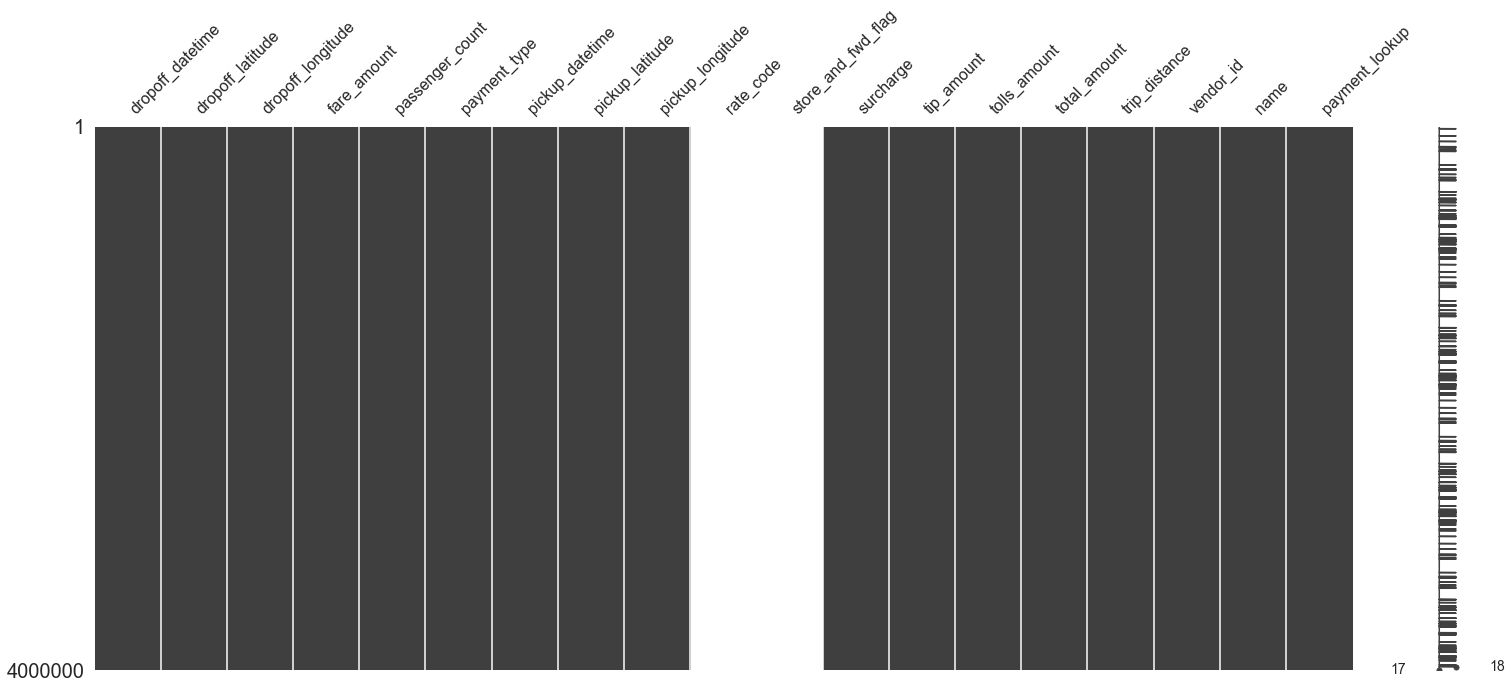

In [12]:
msno.matrix(df);

As shown in the figure, there's only two columns that have a lot of missing values (rate_code and store_and_fwd_flag). As they won't affect our analysis we will just drop them and do some consistency check to see if there's any missing values we didn't see in the figure.

In [12]:
df.drop(columns=['rate_code', 'store_and_fwd_flag'], inplace=True)

In [13]:
df.isna().sum()

dropoff_datetime     0
dropoff_latitude     0
dropoff_longitude    0
fare_amount          0
passenger_count      0
payment_type         0
pickup_datetime      0
pickup_latitude      0
pickup_longitude     0
surcharge            0
tip_amount           0
tolls_amount         0
total_amount         0
trip_distance        0
vendor_id            0
name                 0
payment_lookup       0
dtype: int64

### Feature Engineering - Date Features

We know that we don't have any more missing values. Now we will create some new features based on the pickup and dropoff datetime and locations to perform analysis. We will create features: the time elapsed and the average speed. Those features will be used to visualization and check abnormal values. 

Using the Google Maps, we could check that the *trip_distance* feature is in miles. [Path of first example of the dataset](https://www.google.com.br/maps/dir/40.74295,+-74.004114/40.74795,+-73.994712/@40.7457116,-74.0037917,16z/data=!3m1!4b1!4m10!4m9!1m3!2m2!1d-74.004114!2d40.74295!1m3!2m2!1d-73.994712!2d40.74795!3e2)

In [14]:
df['elapsed_time_hours'] = df.apply(lambda x: (x.dropoff_datetime-x.pickup_datetime).total_seconds()/3600, axis=1)
df['speed_miles_per_h'] = df['trip_distance']/df['elapsed_time_hours']

### Abnormal values

Now we can filter some abnormal values that can be contained on the dataset. Some of the features we will look at:

- trip_distance
- elapsed_time_hours
- speed_miles_per_h
- dropoff_latitude
- dropoff_longitude
- passenger_count
- pickup_latitude
- pickup_longitude
- total_amount

The first thing we can observe is some basic statistics from those features and see if we can find any abnormal value.

In [15]:
df[['trip_distance', 'elapsed_time_hours', 'speed_miles_per_h', 'dropoff_latitude', 'dropoff_longitude', 
    'passenger_count', 'pickup_latitude', 'pickup_longitude', 'total_amount']].describe()

,trip_distance,elapsed_time_hours,speed_miles_per_h,dropoff_latitude,dropoff_longitude,passenger_count,pickup_latitude,pickup_longitude,total_amount
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,2.678209e+00,1.457988e-01,2.021920e+01,4.013500e+01,-7.284804e+01,1.733573e+00,4.012473e+01,-7.283060e+01,1.032687e+01
std,3.130601e+00,4.059804e-02,2.630099e+01,4.986513e+00,9.050543e+00,1.254536e+00,5.026362e+00,9.122395e+00,8.503208e+00
min,0.000000e+00,6.840799e-03,0.000000e+00,-1.520200e-02,-7.919139e+01,0.000000e+00,-9.262000e-03,-8.487835e+01,2.500000e+00
25%,1.000000e+00,1.172772e-01,6.789120e+00,4.073537e+01,-7.399067e+01,1.000000e+00,4.073639e+01,-7.399112e+01,5.700000e+00
50%,1.700000e+00,1.456205e-01,1.199488e+01,4.075449e+01,-7.397953e+01,1.000000e+00,4.075453e+01,-7.398111e+01,7.800000e+00
75%,3.000000e+00,1.742050e-01,2.246880e+01,4.076952e+01,-7.396339e+01,2.000000e+00,4.076844e+01,-7.396681e+01,1.140000e+01
max,4.992000e+01,2.920377e-01,1.548665e+03,4.793581e+01,8.668000e-03,6.000000e+00,4.792285e+01,4.023000e-03,2.300000e+02


In [16]:
df.passenger_count.value_counts()

1    2589416
2     729792
5     339892
3     207760
4     116812
6      15884
0        444
Name: passenger_count, dtype: int64

Analyzing those statistics we can find some intriguing points:

- Trips with 0 miles
- Trips with speed above 150 miles per hour
- Dropoff and pickup coordinates close to 0
- Trips with 0 passengers

For the 0 passengers we also observed that it only represents 444 examples, so we will drop that.

We will consider those abnormal values as errors of typing and will drop them from our dataset. Here are the filters we will consider:

- Since we are considering only the NYC, the latitude and longitude coordinates for NYC were get from Google Maps and are:
    - "min_lat": 40.491588
    - "max_lat": 40.908962
    - "min_lng": -74.263428
    - "max_lng": -73.686467
- Trips have to have a minimum distance of 0.00001 and a maximum speed of 40 miles per hour
- Trips have to have at leat 1 passenger

In [17]:
df = df[
        (df.dropoff_latitude >= 40.491588) & (df.dropoff_latitude <= 40.908962) &
        (df.pickup_latitude >= 40.491588) & (df.pickup_latitude <= 40.908962) &
        (df.dropoff_longitude >= -74.263428) & (df.dropoff_longitude <= -73.686467) &
        (df.pickup_longitude >= -74.263428) & (df.pickup_longitude <= -73.686467) &
        (df.trip_distance >= 0.00001) & (df.speed_miles_per_h <= 40) &
        (df.passenger_count > 0)
       ]

In [18]:
df.shape

(3450958, 19)

After filtering we stay with $86.3\%$ of the original data and now the data is more reliable and we can study and have some visualizations to understand the behaviour of the data and get insights about the NYC taxi trips.

### Map of pickup and dropoff locations

Let's start plotting the pickup and dropoff locations from 2010 in a map view to check if there's any concentration of points.

For that we opted to not use any external library, so the steps to make the plot are the following

- First, get the image on [openstreetmap.org](https://www.openstreetmap.org/export#map=5/51.500/-0.100)
- Then plot the image and the points
- Set the bounding boxes of the image to the latitude and longitude limits

In [20]:
map_image = plt.imread('map.png')

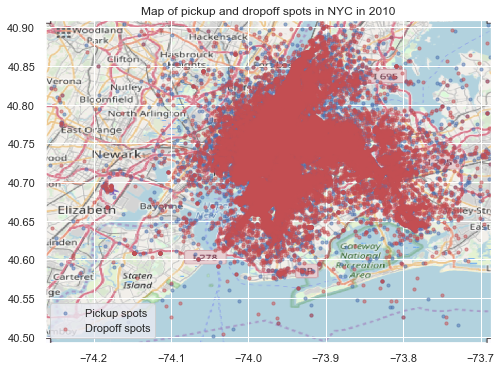

In [21]:
BBox = (-74.263428, -73.686467,      
         40.491588, 40.908962)
        
fig, ax = plt.subplots(figsize = (8,8));
ax.scatter(df[df.pickup_datetime.dt.year == 2010].pickup_longitude, df[df.pickup_datetime.dt.year == 2010].pickup_latitude, zorder=1, alpha= 0.5, c='b', s=10, label="Pickup spots");
ax.scatter(df[df.pickup_datetime.dt.year == 2010].dropoff_longitude, df[df.pickup_datetime.dt.year == 2010].dropoff_latitude, zorder=1, alpha= 0.5, c='r', s=10, label="Dropoff spots");
ax.set_title('Map of pickup and dropoff spots in NYC in 2010');
ax.set_xlim(BBox[0],BBox[1]);
ax.set_ylim(BBox[2],BBox[3]);
ax.imshow(map_image, zorder=0, extent = BBox, aspect= 'equal');
ax.legend();

As we can see in the map, there's some inconsistent spots in the ocean. Probably, that's due the inaccurate GPS location and as it's very close to the NYC we will consider them. We can also observe that the trips are all over the city.

### Number of trips

Now, we will draw some plots to observe the number of trips over the last three months of the years to observe if there's any peak due to the holidays and to observe if the number of trips had increased over the years.

In [22]:
df_plot = df[(df.pickup_datetime.dt.month >= 10)].copy()
df_plot = df_plot[['dropoff_datetime', 'pickup_datetime']].set_index('pickup_datetime').groupby(pd.Grouper(freq='D')).count().reset_index()
df_plot['year'] = df_plot.pickup_datetime.dt.year
df_plot['date'] = pd.to_datetime(df_plot.pickup_datetime.dt.strftime('%m-%d')+'-2000')
df_plot.columns = ['pickup_datetime', 'count', 'year', 'date']

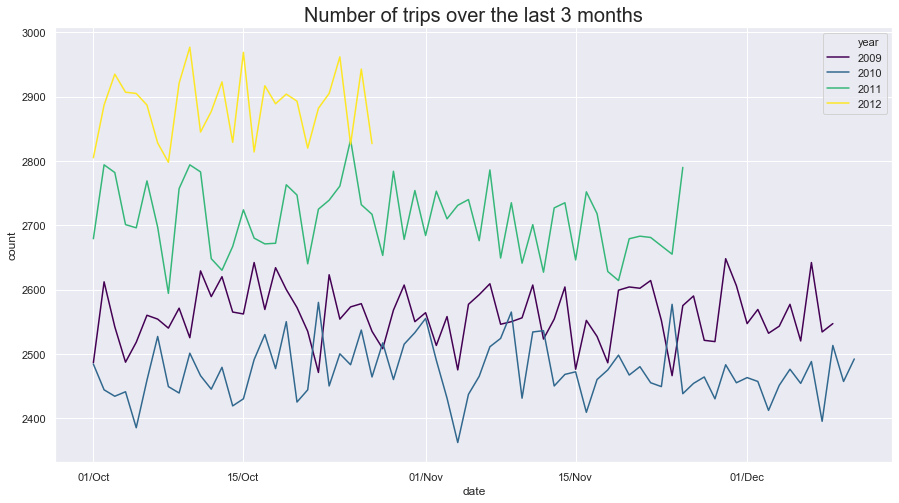

In [23]:
sns.lineplot(x="date", y="count", palette='viridis', hue = 'year', data=df_plot[df_plot['count'] > 0].sort_values('date'));
# get current axis
ax = plt.gca()
# convert all xtick labels to selected format from ms timestamp
ax.set_xticklabels(['01/Oct', '15/Oct', '01/Nov', '15/Nov', '01/Dec']);
ax.set_title('Number of trips over the last 3 months', fontsize = 20);

We can observe that only 2009 and 2010 has data for december and they have only until the 15th day, so we don't have enough data to conclude if there's any change in the number of trips because of the holidays. Besides that we can conclude that the number of trips has increased over the years with 300ish more trips per day.

### Average distance traveled by number of passengers

Now let's see if there's any difference between the average distance of trips with at least 2 passengers and 3 or more. 

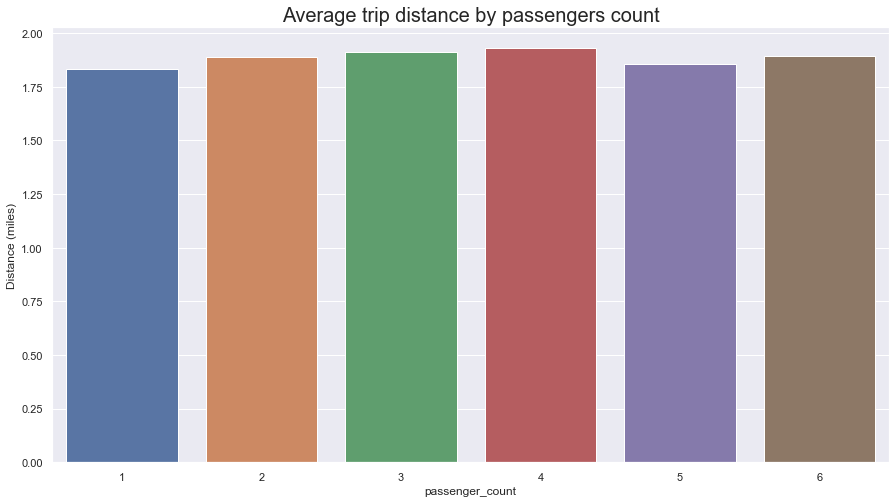

In [36]:
df_plot = df[['trip_distance', 'passenger_count']].groupby(by=['passenger_count']).mean().reset_index()
sns.barplot(x="passenger_count", y="trip_distance", data=df_plot);

ax = plt.gca()
ax.set_title('Average trip distance by passengers count', fontsize = 20);
ax.set_ylabel('Distance (miles)');

In [26]:
print("Average distance of trips with a maximum of 2 passengers:", df[df.passenger_count <= 2]['trip_distance'].mean())
print("Average distance of trips with a minimum of 3 passengers:", df[df.passenger_count > 2]['trip_distance'].mean())

Average distance of trips with a maximum of 2 passengers: 1.8442819588761425
Average distance of trips with a minimum of 3 passengers: 1.8870256224112107


As shown above, there's no significant difference between the distance traveled by different number of passengers.

### Biggest vendor

Next insight we want to generate is wich are the biggest vendors based on the total amount of money they raised over the year.

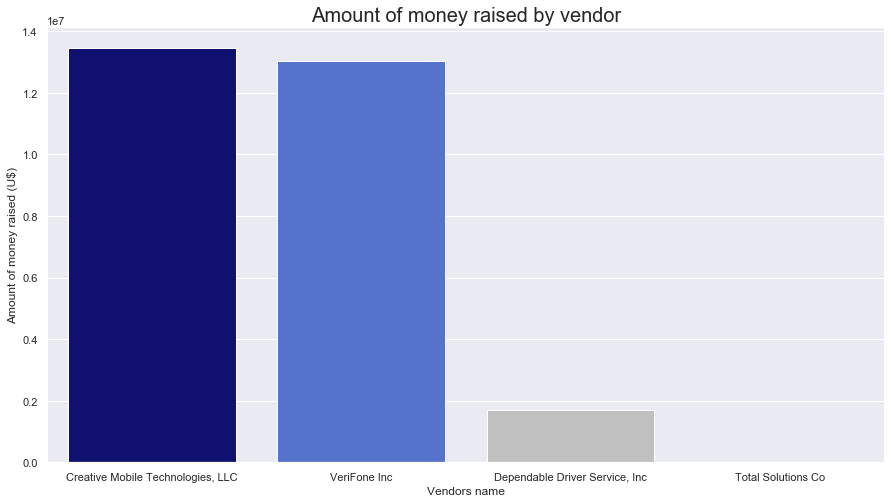

In [34]:
df_plot = df[['total_amount', 'name']].groupby(by=['name']).sum().reset_index()
sns.barplot(x="name", y="total_amount", data=df_plot.sort_values('total_amount', ascending=False), palette=['navy', 'royalblue', 'silver', 'silver']);

ax = plt.gca()
ax.set_title('Amount of money raised by vendor', fontsize = 20);
ax.set_ylabel('Amount of money raised (U$)');
ax.set_xlabel('Vendors name');

So, Creative Mobile Technologies and VeriFone had raised way much more money than the others vendors, with Dependable Driver Service being the third with only $12\%$ of the money raised if compared with the top 2.

Another insight is that Total Solutions had very distinct graphs, so we looked up how many trips each one of the vendors has made and we discovered that Total Solutions has only 4 examples, and we will remove them from the data

In [72]:
df.name.value_counts()

Creative Mobile Technologies, LLC    1647045
VeriFone Inc                         1596376
Dependable Driver Service, Inc        207533
Total Solutions Co                         4
Name: name, dtype: int64

In [74]:
df = df[df.name != "Total Solutions Co"]

And the vendors affects the price of the ride?

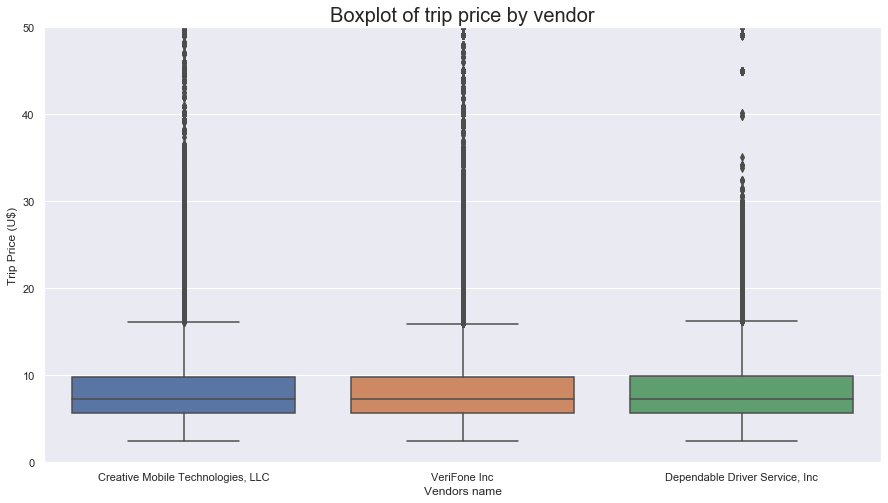

In [84]:
df_plot = df[['total_amount', 'name']]
sns.boxplot(x="name", y="total_amount", data=df_plot);

ax = plt.gca()
ax.set_title('Boxplot of trip price by vendor', fontsize = 20);
ax.set_ylabel('Trip Price (U$)');
ax.set_ylim(0,50);
ax.set_xlabel('Vendors name');

And then we find that vendors does have similar distibutions of price and there's no significant difference between them.

### Weekends

How does the weekday affects the time of travel of the trips? And the price of the ride? Here we find if there's any important feature to add to our predective model.

In [86]:
df_plot = df[['total_amount', 'pickup_datetime', 'elapsed_time_hours']].copy()
df_plot['weekday'] = df_plot.pickup_datetime.dt.weekday
df_plot['elapsed_time_min'] = df_plot.elapsed_time_hours*60

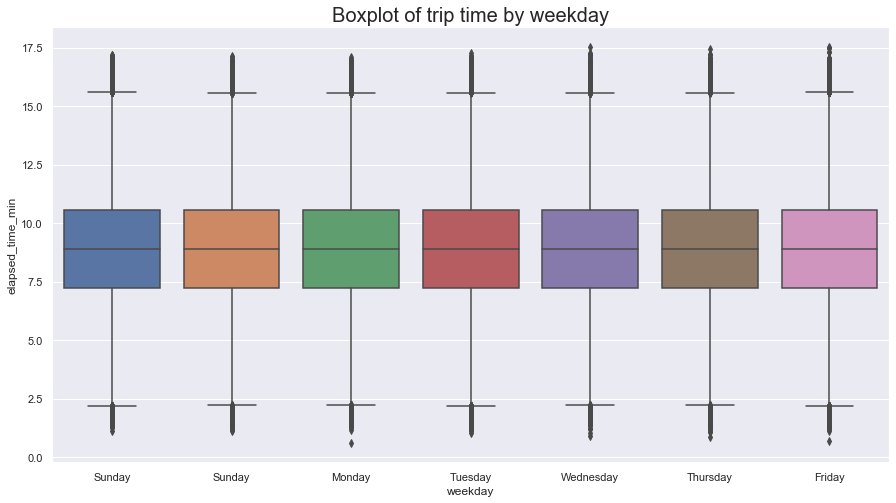

In [76]:
sns.boxplot(x="weekday", y="elapsed_time_min", data=df_plot);

ax = plt.gca()
ax.set_title('Boxplot of trip time by weekday', fontsize = 20);
ax.set_xticklabels(['Sunday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']);

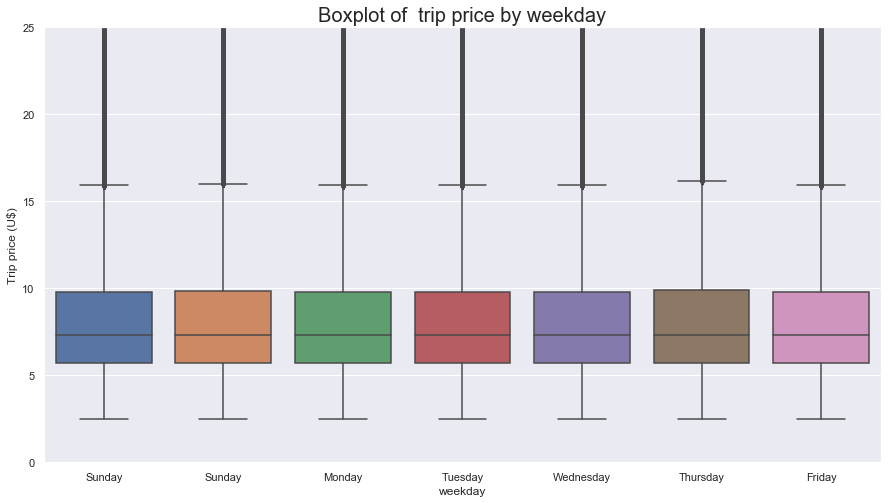

In [88]:
sns.boxplot(x="weekday", y="total_amount", data=df_plot);

ax = plt.gca()
ax.set_title('Boxplot of  trip price by weekday', fontsize = 20);
ax.set_ylabel('Trip price (U$)');
ax.set_ylim(0,25)
ax.set_xticklabels(['Sunday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']);

What we found:

- The weekday - mainly the weekend - surprisingly doesn't affect the distibution of time and price of the trips, and we will not consider this feature in our predictive model.

### Hour of the day

And the hour of the day can actually affect the price and the time of trips? Similarly to the weekday we will observe the distributions for the hour of the day and decide to use or not as a feature.

In [90]:
df_plot = df[['total_amount', 'pickup_datetime', 'elapsed_time_hours']].copy()
df_plot['hour'] = df_plot.pickup_datetime.dt.hour
df_plot['elapsed_time_min'] = df_plot.elapsed_time_hours*60

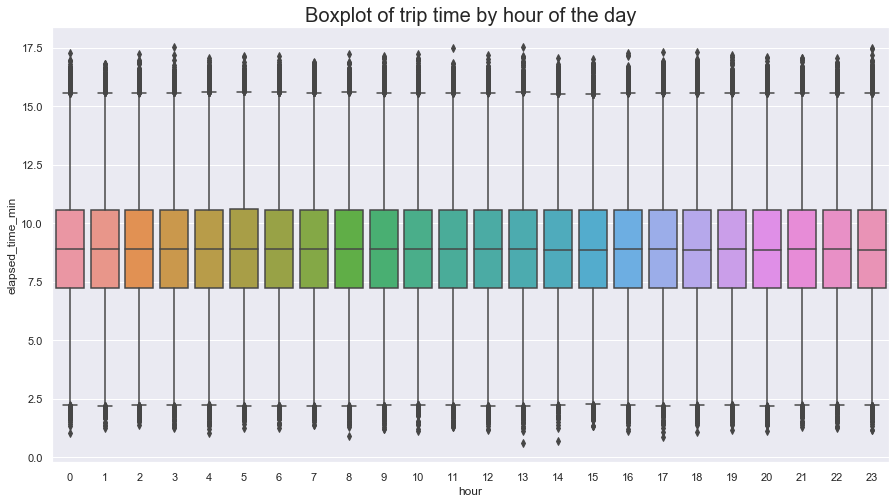

In [91]:
sns.boxplot(x="hour", y="elapsed_time_min", data=df_plot);

ax = plt.gca()
ax.set_title('Boxplot of trip time by hour of the day', fontsize = 20);

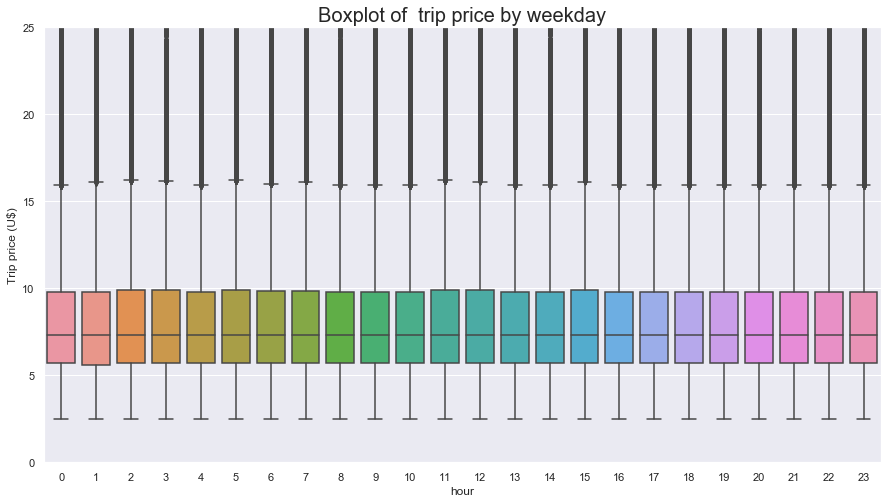

In [93]:
sns.boxplot(x="hour", y="total_amount", data=df_plot);

ax = plt.gca()
ax.set_title('Boxplot of  trip price by weekday', fontsize = 20);
ax.set_ylabel('Trip price (U$)');
ax.set_ylim(0,25);

We also found that there's any difference between the hours of day for the price and time.

*Note: If you look at the data for each year you can understand those results, as the data is very similar, changing only the dates.*

### Daily distribution of fare amount

To confirm that the day doesn't affect the price of a ride, let's look at the distribution of the daily distribution of the average fare of the rides on each day.

In [149]:
df_plot = df[['total_amount', 'pickup_datetime']]\
                .set_index('pickup_datetime').groupby(pd.Grouper(freq='D')).mean().reset_index()

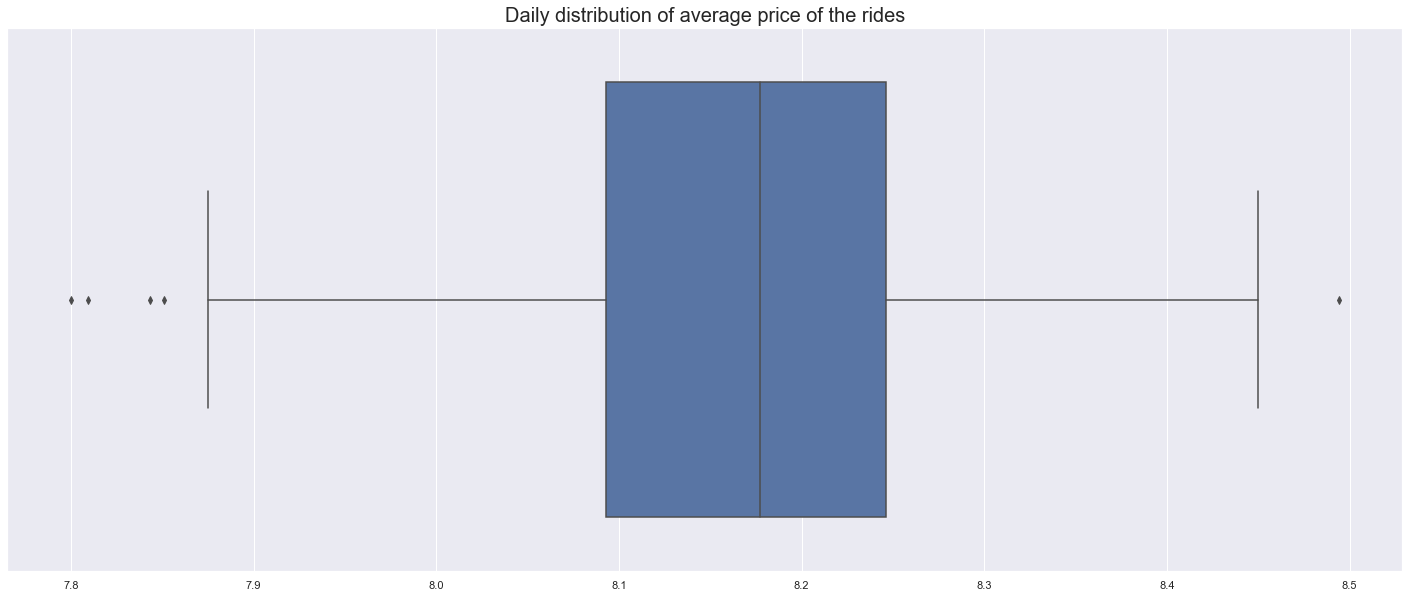

In [158]:
sns.boxplot(df_plot[df_plot.total_amount > 0].total_amount.values);

ax = plt.gca()
ax.set_title('Daily distribution of average price of the rides', fontsize = 20);

We can observe that there isn't a big range of values (less than a dollar), so the day isn't affecting the price of the ride.

### Monthly distribution

Now we want to understand what is the monthly distribution over the years for the number of rides and the total amount of the trips.

In [100]:
df_plot = df[['total_amount', 'pickup_datetime']].set_index('pickup_datetime')\
                                                 .groupby(pd.Grouper(freq='M')).agg(['count', 'sum'])
df_plot = df_plot[df_plot[('total_amount', 'count')]>0]

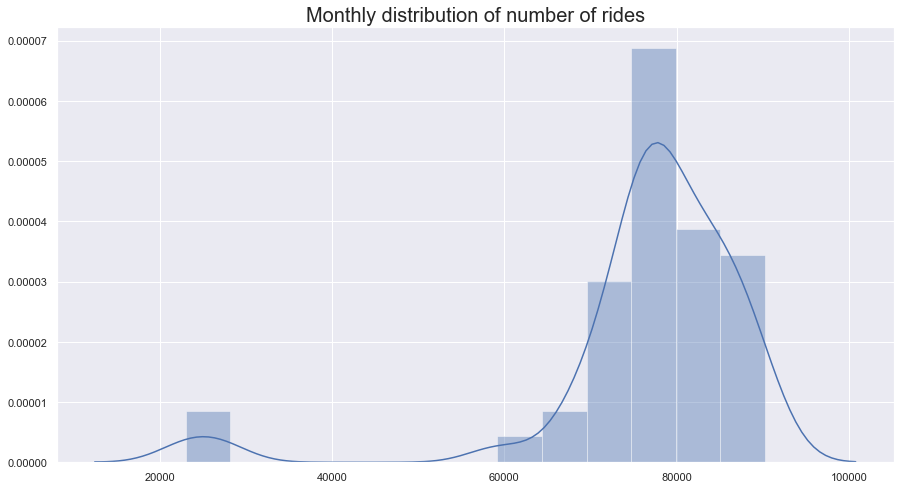

In [102]:
sns.distplot(df_plot[('total_amount', 'count')].values);

ax = plt.gca()
ax.set_title('Monthly distribution of number of rides', fontsize = 20);

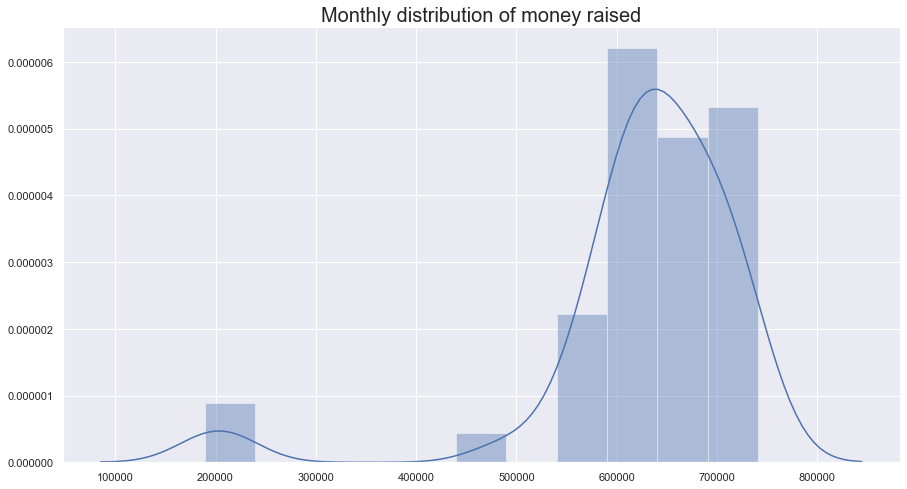

In [105]:
sns.distplot(df_plot[('total_amount', 'sum')].values);

ax = plt.gca()
ax.set_title('Monthly distribution of money raised', fontsize = 20);

We can observe that mostly of the months are near 70000 trips per month, raising an amount of 700ish thousand dollars. We have some months with a lower number of trips, but probably it's december, because it's missing data for the month.

### Seasonality

The last thing we will study is if there is any kind of seasonality in the time series of the number of trips. For that we will do 2 types of analysis:

- The first one we will perform the time series decomposition using the *statsmodels* package. Maybe you are wondering what's time series decomposition? Well, it's a statiscal tool to decompose a time series in 4 components: 
    - Trend, which reflects the long-term progression of the series
    - Cyclical component, which reflects repeated but non-periodic fluctuations
    - The seasonal component, reflecting seasonality
    - And the irregular component (or "noise"), wich describes random, irregular influences.
   So we will look at the seasonal component and see if there's any signal.

- In the second analysis we will use the Autocorrelation function (ACF). This is an analysis of the autocorrelation using lags and then if there's a high correlation between them we can confirm that there's a seasonality of the size of the lag.

In [123]:
df_plot = df[['dropoff_datetime', 'pickup_datetime']]\
            .set_index('pickup_datetime').groupby(pd.Grouper(freq='D')).count().reset_index()
df_plot['pickup_datetime'] = df_plot.pickup_datetime.dt.date
df_plot = df_plot.set_index('pickup_datetime')

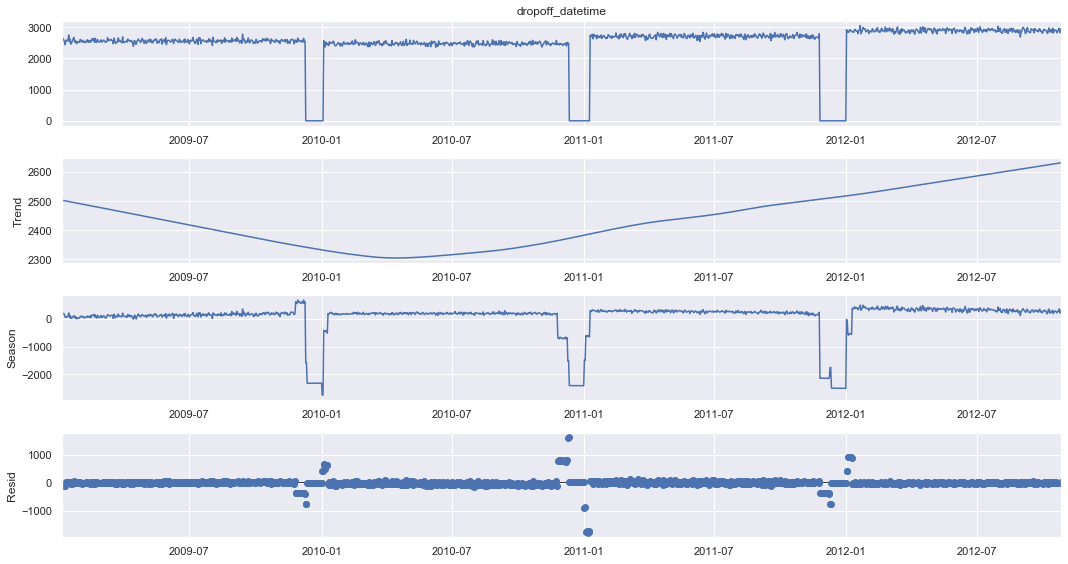

In [131]:
series = df_plot.dropoff_datetime
result = STL(series, period=365).fit()
chart = result.plot()
plt.show()

With the time series decomposition we can observe that the seasonality caught was because of the missing data from december. A good insight is that the number of rides started do increase since 2010 being a positive trend. Now let's look at the ACF to see if we have better results.

In [133]:
results = acf(df_plot.dropoff_datetime.values, unbiased=True, nlags=365)

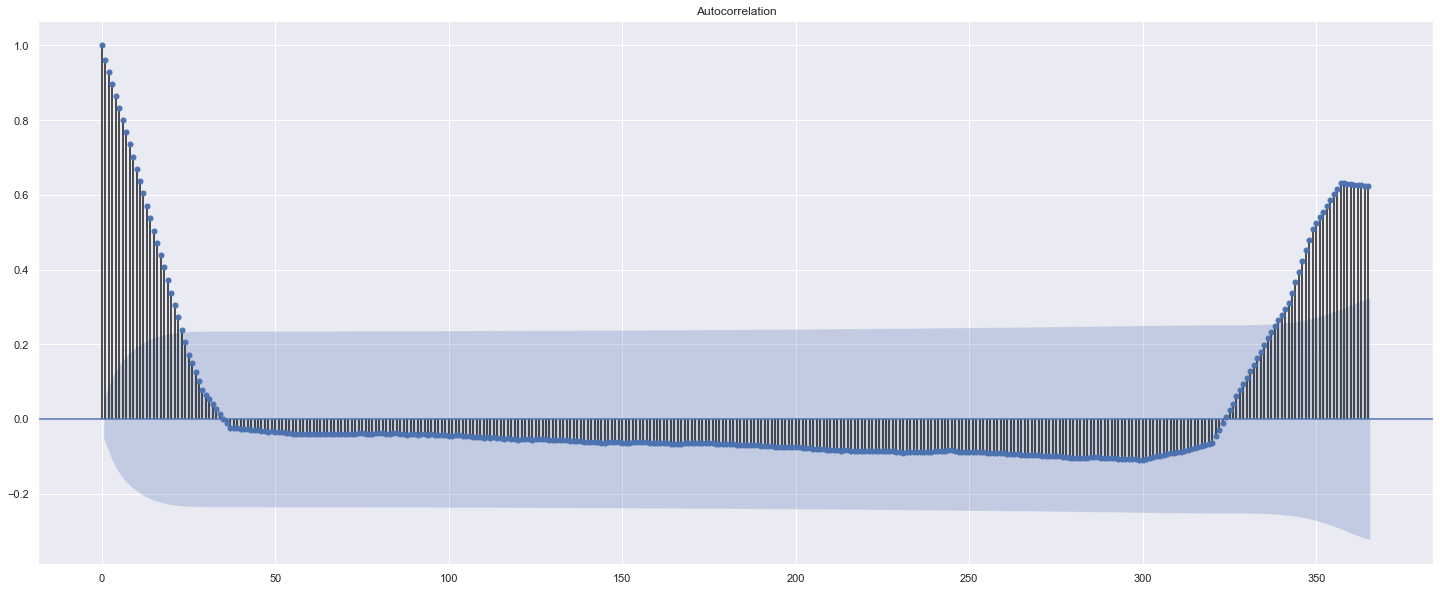

In [147]:
plt.rcParams['figure.figsize'] = [25, 10]
sm.graphics.tsa.plot_acf(df_plot.dropoff_datetime.values, unbiased=True, lags=365)
plt.show()

The blue shadow on the plot represents a threshold to determine if it's correlated or not. So, with the ACF plot we can see that there's some monthly seasonality (values above 0.2 until the lag 30) and an anual seasonality (values above 0.2 after lag 340). So we can observe those 2 seasonalities on our data.

Now that we have analyzed our data and we finished the visualizations, let's build some machine learning models to predict the price of a ride (including tolls) using the coordinates of pickup and dropoff locations.

## Predicting fare amount

The first thing to do is to select the features we will use:

- As we are predicting the fare amount, we will remove the price of the tip on the total amount.
- As we saw that no datetime or vendors feature are discriminating  for the fare amount, we will use only the coordinates to predict the price

In [188]:
X = df[['dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude']]
y = df['fare_amount']+df['tolls_amount']

### Test set

We will separate some data to test our models. For that we will radomly choose $1\%$ of our dataset to be used as test set. We use only $1\%$ because there's a lot of data avaiable.

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

### Random search and K-fold cross validation

For all our models we will use 2 techniques to choose the best hyperparameters and to ensure the generalization of the model. First we will use the Random search to use random combinations of hyperparameters (without using all combinations - save computer processing) and with that we will divide the training data into 10 folds to perform the cross validation. How that works? For choose the best combination of hyperparameter and to not overfit the model, we have to validate the results of the data. So using the K-fold technique we can split the data into K groups and evaluate the hyperparameters with K differents data and wich set of hyperparameters has the best average result is chosen as the best one. We can implement the K-fold with the following steps:

- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
    - Take the group as a hold out or test data set
    - Take the remaining groups as a training data set
    - Fit a model on the training set and evaluate it on the test set
    - Retain the evaluation score and discard the model
- Summarize the skill of the model using the sample of model evaluation scores

Then the models are compared with their results on the test set. With that we guarantee that we are choosing the best general model.

### Metrics

As we are dealing with a regression model, we will use the MAE (Mean Absolute Error) to evaluate the models and choose the best one.

Now, let's start building the models.

### Baseline

The first model we will build is an KNN Regressor. It's a simple model that uses the mean or median value K-nearest neighbours to predict a new point. We will build this simpler model to have an baseline an try to be better than that, but somitimes the baseline are just what we need.

In [190]:
knn = KNeighborsRegressor()
parameters = {'n_neighbors' : list(range(1,11))}
clf = RandomizedSearchCV(knn, parameters, random_state=42, cv = 10, 
                         scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
search = clf.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished


In [191]:
print('Best set of hyperparameters:', search.best_params_)

Best set of hyperparameters: {'n_neighbors': 1}


In [192]:
print('Validation set MAE:', -search.best_score_)
print('Test set MAE:', -search.score(X_test, y_test))

Validation set MAE: 0.037383132871488596
Test set MAE: 0.035063749637786155


As expected, because we have some duplicate values (each year has the same values, changing only the date), using the price of the nearest data we have a average MAE of 3.8 cents on validation sets, wich is pretty amazing. We can observe that with the counting of duplicate values below. Trying to have more challenge, we will use only the data from 2012 to build our models. We will rebuild the baseline model with the data and let's see if something changes.

In [178]:
X_train.groupby(X_train.columns.tolist(),as_index=False).size().head()

dropoff_latitude  dropoff_longitude  pickup_latitude  pickup_longitude
40.503987         -74.033053         40.501272        -74.046320          4
40.517895         -73.961165         40.517895        -73.961165          4
40.518417         -73.744442         40.515842        -73.729367          3
40.524298         -73.963290         40.545870        -74.012458          4
40.525173         -74.100275         40.560555        -74.024868          4
dtype: int64

In [193]:
df_ml = df[df.pickup_datetime.dt.year == 2012]
X = df_ml[['dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude']]
y = df_ml['fare_amount']+df_ml['tolls_amount']

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

In [210]:
knn = KNeighborsRegressor()
parameters = {'n_neighbors' : list(range(1,11))}
grid = RandomizedSearchCV(knn, parameters, random_state=42, cv = 10, 
                         scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
search = grid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


In [196]:
test_results = {}

In [211]:
test_results['KNN'] = -search.score(X_test, y_test)
print('Best set of hyperparameters:', search.best_params_)
print('Validation set MAE:', -search.best_score_)
print('Test set MAE:', test_results['KNN'])

Best set of hyperparameters: {'n_neighbors': 40}
Validation set MAE: 0.9785152595077127
Test set MAE: 0.9825895492275768


Now we have some challenge. Our base line model is missing an average of 1 dollar on the test set. Now we will try to decrease our error with other models.

### ElasticNet

The first model we will try to beat the baseline is the elasticNet. This model fits a linear regression with some regularization parameters.

In [201]:
parametersGrid = {"max_iter": [3, 5, 10],
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet()
grid = RandomizedSearchCV(eNet, parametersGrid, random_state=42, cv = 10, 
                         scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
search = grid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


In [202]:
test_results['ElasticNet'] = -search.score(X_test, y_test)
print('Best set of hyperparameters:', search.best_params_)
print('Validation set MAE:', -search.best_score_)
print('Test set MAE:', test_results['ElasticNet'])

Best set of hyperparameters: {'max_iter': 3, 'l1_ratio': 0.30000000000000004, 'alpha': 0.0001}
Validation set MAE: 2.550655915320488
Test set MAE: 2.5780023624086823


So the elasticNet isn't performing very well with our dataset. Now we will try the Random Forest trying to achieve better results.

### Random Forest

In [208]:
# Number of trees in random forest
n_estimators = [5, 10, 15]
# Maximum number of levels in tree
max_depth = [10, 20, 30]
# Minimum number of samples required to split a node
min_samples_split = [2, 10, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 30, 50]
# Create the random grid
parametersGrid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestRegressor(random_state = 42)
grid = RandomizedSearchCV(rf, parametersGrid, random_state=42, cv = 10,
                         scoring='neg_mean_absolute_error', verbose=5, n_jobs=-1)
search = grid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished


In [209]:
test_results['Random Forest'] = -search.score(X_test, y_test)
print('Best set of hyperparameters:', search.best_params_)
print('Validation set MAE:', -search.best_score_)
print('Test set MAE:', test_results['Random Forest'])

Best set of hyperparameters: {'n_estimators': 10, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_depth': 30}
Validation set MAE: 1.0463702630577723
Test set MAE: 1.049908555203813


We achieved similar results to KNN, but not better. Now let's try a last model, a Multi-layer Perceptron regressor. This is a shallow neural network and we will try to use the non-linear functions to see if it makes a better model.

### MLP

First, for Neural Networks we have to standardize the data, so we avoid some troubles with the neurons as exploding gradients.

In [217]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [218]:
parametersGrid = {'hidden_layer_sizes': [(10,5), (10,), (8,4), (8,)],
               'activation': ['relu', 'tanh'],
               'solver': ['sgd', 'adam']}

mlp = MLPRegressor(random_state = 42, batch_size=10000)
grid = RandomizedSearchCV(mlp, parametersGrid, random_state=42, cv = 10,
                         scoring='neg_mean_absolute_error', verbose=5, n_jobs=-1)
search = grid.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 30.1min finished


In [219]:
test_results['MLP'] = -search.score(X_test_scaled, y_test)
print('Best set of hyperparameters:', search.best_params_)
print('Validation set MAE:', -search.best_score_)
print('Test set MAE:', test_results['MLP'])

Best set of hyperparameters: {'solver': 'adam', 'hidden_layer_sizes': (10, 5), 'activation': 'relu'}
Validation set MAE: 1.0781906172614117
Test set MAE: 1.0971821109892406


And then, the famous Neural Networks hasn't done a better job than Random Forest and KNN. Below we have an graph just to compare the models. The KNN was our baseline and our best model and it has a simple explanation: Trips with near pickup and dropoff locations will have similar prices.

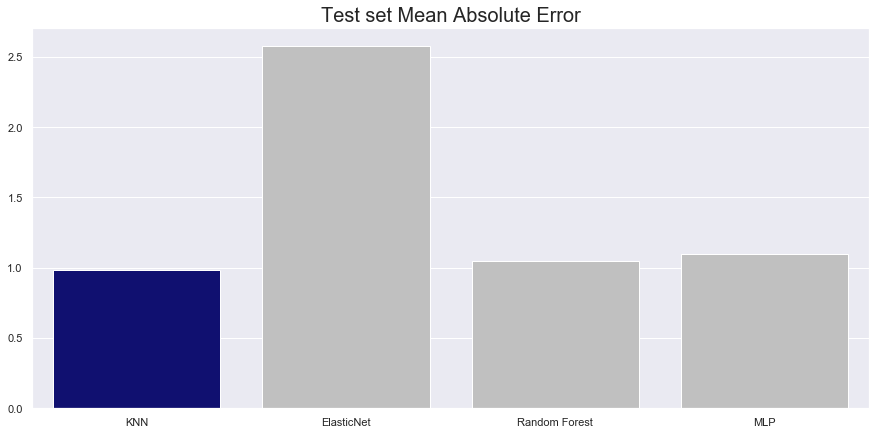

In [230]:
plt.rcParams['figure.figsize'] = [15, 7]
sns.barplot(x=list(test_results.keys()), y=list(test_results.values()), palette=['navy', 'silver', 'silver', 'silver'])

ax = plt.gca()
ax.set_title('Test set Mean Absolute Error', fontsize = 20);

## Conclusion

I think that's all. We had all the steps to analyze and create some insights from the data (data cleaning, feature engineering, data visualization) and applied some machine learning models to predict the fare amount of a ride given the pickup and dropoff locations. I hope you have enjoyed this extensive notebook and please, any doubts contact me.